In [ ]:
!pip install pennylane

In [ ]:
!pip install qiskit

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# import qiskit
# from qlstm_pennylane import QLSTM

Here we define the possible tags: determinant, noun, verb.

In [ ]:
tag_to_ix = {"DET": 0, "NN": 1, "V": 2, "PRON":3,  "ADV":4, "ADJ":5, "IN":6}  # Assign each tag with a unique index
ix_to_tag = {i:k for k,i in tag_to_ix.items()}

The function below tokenizes the sentence and matches the label to each word.

In [ ]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

Now we can prepare the input dataset.

In [ ]:
vocab = [
    # Tags are: DET - determiner; NN - noun; V - verb
    # For example, the word "The" is a determiner
    ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
    ("Everybody read that book".split(), ["NN", "V", "DET", "NN"]),
    ("She sings beautifully".split(), ["PRON", "V", "ADV"]),
    ("The big red apple fell from the tree".split(), ["DET", "ADJ", "ADJ", "NN", "V", "IN", "DET", "NN"]),
    ("They ran quickly to the park".split(), ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("He read the book slowly".split(), ["PRON", "V", "DET", "NN", "ADV"]),
    ("The dogs barked loudly".split(), ["DET", "NN", "V", "ADV"]),
    ("The tall building stood alone in the city".split(), ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    ("She ate a delicious cake for dessert".split(), ["PRON", "V", "DET", "ADJ", "NN", "IN", "NN"]),
    ("The children played happily in the park".split(), ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "cats", "slept", "on", "the", "mat."], ["DET", "NN", "V", "IN", "DET", "NN"]),
    (["She", "dances", "gracefully", "on", "stage."], ["PRON", "V", "ADV", "IN", "NN"]),
    (["The", "flowers", "bloomed", "beautifully", "in", "the", "garden."], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "walked", "slowly", "down", "the", "street."], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "children", "played", "happily", "at", "the", "park."], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "ran", "quickly", "to", "catch", "the", "bus."], ["PRON", "V", "ADV", "IN", "V", "DET", "NN"]),
    (["The", "big", "yellow", "sun", "set", "over", "the", "ocean."], ["DET", "ADJ", "ADJ", "NN", "V", "IN", "DET", "NN"]),
    (["She", "wore", "a", "pretty", "dress", "to", "the", "party."], ["PRON", "V", "DET", "ADJ", "NN", "IN", "DET", "NN"]),
    (["The", "old", "men", "sat", "alone", "on", "the", "bench."], ["DET", "ADJ", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "cat", "jumped", "over", "the", "fence"], ["DET", "NN", "V", "IN", "DET", "NN"]),
    (["A", "bird", "sang", "beautifully", "in", "the", "morning"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "ran", "quickly", "to", "catch", "the", "bus"], ["PRON", "V", "ADV", "IN", "V", "DET", "NN"]),
    (["The", "students", "studied", "hard", "for", "the", "exam"], ["DET", "NN", "V", "ADJ", "IN", "DET", "NN"]),
    (["He", "ate", "his", "dinner", "quietly"], ["PRON", "V", "DET", "NN", "ADV"]),
    (["The", "sun", "shone", "brightly", "on", "the", "beach"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "played", "happily", "in", "the", "park"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "flowers", "bloomed", "vividly", "in", "the", "garden"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "slept", "peacefully", "throughout", "the", "night"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "children", "laughed", "joyfully", "at", "the", "joke"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "spoke", "softly", "to", "his", "mother"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "baby", "cried", "loudly", "in", "the", "room"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "danced", "gracefully", "on", "the", "stage"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "horses", "galloped", "swiftly", "across", "the", "field"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "read", "carefully", "the", "instructions"], ["PRON", "V", "ADV", "DET", "NN"]),
    (["The", "dog", "barked", "loudly", "at", "the", "stranger"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "swam", "gracefully", "in", "the", "ocean"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "paintings", "displayed", "beautifully", "in", "the", "gallery"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "wrote", "passionately", "about", "his", "experiences"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "sun", "set", "slowly", "behind", "the", "mountains"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "spoke", "confidently", "in", "front", "of", "the", "audience"], ["PRON", "V", "ADV", "IN", "NN", "IN", "DET", "NN"]),
    (["The", "children", "played", "happily", "in", "the", "park"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "smiled", "warmly", "at", "his", "friends"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "car", "drove", "swiftly", "along", "the", "highway"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "answered", "quickly", "to", "his", "question"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    (["The", "students", "listened", "attentively", "to", "the", "lecture"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "climbed", "bravely", "to", "the", "mountain", "peak"], ["PRON", "V", "ADV", "IN", "DET", "NN", "NN"]),
    (["The", "rain", "fell", "heavily", "on", "the", "roof"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["She", "ran", "frantically", "to", "catch", "the", "bus"], ["PRON", "V", "ADV", "IN", "V", "DET", "NN"]),
    (["The", "flowers", "bloomed", "colorfully", "in", "the", "garden"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["He", "ate", "hungrily", "after", "a", "long", "day"], ["PRON", "V", "ADV", "IN", "DET", "ADJ", "NN"]),
    (["The", "cat", "purred", "contentedly", "on", "the", "windowsill"], ["DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
    (["They", "played", "enthusiastically", "in", "the", "playground"], ["PRON", "V", "ADV", "IN", "DET", "NN"]),
    ("We heard the birds chirping loudly in the morning".split(), ["PRON", "V", "DET", "NN", "V", "ADV", "IN", "DET", "NN"]),
]
word_to_ix = {}
training_data=vocab[:len(vocab)-1]
# For each words-list (sentence) and tags-list in each tuple of training_data
for sent, tags in vocab:
    for word in sent:
        if word not in word_to_ix:  # word has not been assigned an index yet
            word_to_ix[word] = len(word_to_ix)  # Assign each word with a unique index

print(f"Vocabulary: {word_to_ix}")
print(f"Entities: {ix_to_tag}")

Vocabulary: {'The': 0, 'dog': 1, 'ate': 2, 'the': 3, 'apple': 4, 'Everybody': 5, 'read': 6, 'that': 7, 'book': 8, 'She': 9, 'sings': 10, 'beautifully': 11, 'big': 12, 'red': 13, 'fell': 14, 'from': 15, 'tree': 16, 'They': 17, 'ran': 18, 'quickly': 19, 'to': 20, 'park': 21, 'He': 22, 'slowly': 23, 'dogs': 24, 'barked': 25, 'loudly': 26, 'tall': 27, 'building': 28, 'stood': 29, 'alone': 30, 'in': 31, 'city': 32, 'a': 33, 'delicious': 34, 'cake': 35, 'for': 36, 'dessert': 37, 'children': 38, 'played': 39, 'happily': 40, 'cats': 41, 'slept': 42, 'on': 43, 'mat.': 44, 'dances': 45, 'gracefully': 46, 'stage.': 47, 'flowers': 48, 'bloomed': 49, 'garden.': 50, 'walked': 51, 'down': 52, 'street.': 53, 'at': 54, 'park.': 55, 'catch': 56, 'bus.': 57, 'yellow': 58, 'sun': 59, 'set': 60, 'over': 61, 'ocean.': 62, 'wore': 63, 'pretty': 64, 'dress': 65, 'party.': 66, 'old': 67, 'men': 68, 'sat': 69, 'bench.': 70, 'cat': 71, 'jumped': 72, 'fence': 73, 'A': 74, 'bird': 75, 'sang': 76, 'morning': 77, 'b

In [ ]:
training_data

[(['The', 'dog', 'ate', 'the', 'apple'], ['DET', 'NN', 'V', 'DET', 'NN']),
 (['Everybody', 'read', 'that', 'book'], ['NN', 'V', 'DET', 'NN']),
 (['She', 'sings', 'beautifully'], ['PRON', 'V', 'ADV']),
 (['The', 'big', 'red', 'apple', 'fell', 'from', 'the', 'tree'],
  ['DET', 'ADJ', 'ADJ', 'NN', 'V', 'IN', 'DET', 'NN']),
 (['They', 'ran', 'quickly', 'to', 'the', 'park'],
  ['PRON', 'V', 'ADV', 'IN', 'DET', 'NN']),
 (['He', 'read', 'the', 'book', 'slowly'], ['PRON', 'V', 'DET', 'NN', 'ADV']),
 (['The', 'dogs', 'barked', 'loudly'], ['DET', 'NN', 'V', 'ADV']),
 (['The', 'tall', 'building', 'stood', 'alone', 'in', 'the', 'city'],
  ['DET', 'ADJ', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']),
 (['She', 'ate', 'a', 'delicious', 'cake', 'for', 'dessert'],
  ['PRON', 'V', 'DET', 'ADJ', 'NN', 'IN', 'NN']),
 (['The', 'children', 'played', 'happily', 'in', 'the', 'park'],
  ['DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']),
 (['The', 'cats', 'slept', 'on', 'the', 'mat.'],
  ['DET', 'NN', 'V', 'IN', 'DET', 'N

In [ ]:
import torch
import torch.nn as nn

import pennylane as qml


class QLSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                n_qubits=4,
                n_qlayers=1,
                batch_first=True,
                return_sequences=False,
                return_state=False,
                backend="default.qubit"):
        super(QLSTM, self).__init__()
        self.n_inputs = input_size
        self.hidden_size = hidden_size
        self.concat_size = self.n_inputs + self.hidden_size
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.batch_first = batch_first
        self.return_sequences = return_sequences
        self.return_state = return_state

        #self.dev = qml.device("default.qubit", wires=self.n_qubits)
        #self.dev = qml.device('qiskit.basicaer', wires=self.n_qubits)
        #self.dev = qml.device('qiskit.ibm', wires=self.n_qubits)
        # use 'qiskit.ibmq' instead to run on hardware

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.clayer_in = torch.nn.Linear(self.concat_size, n_qubits)
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)
        #self.clayer_out = [torch.nn.Linear(n_qubits, self.hidden_size) for _ in range(4)]

    def forward(self, x, init_states=None):
        '''
        x.shape is (batch_size, seq_length, feature_size)
        recurrent_activation -> sigmoid
        activation -> tanh
        '''
        if self.batch_first is True:
            batch_size, seq_length, features_size = x.size()
        else:
            seq_length, batch_size, features_size = x.size()

        hidden_seq = []
        if init_states is None:
            h_t = torch.zeros(batch_size, self.hidden_size)  # hidden state (output)
            c_t = torch.zeros(batch_size, self.hidden_size)  # cell state
        else:
            # for now we ignore the fact that in PyTorch you can stack multiple RNNs
            # so we take only the first elements of the init_states tuple init_states[0][0], init_states[1][0]
            h_t, c_t = init_states
            h_t = h_t[0]
            c_t = c_t[0]

        for t in range(seq_length):
            # get features from the t-th element in seq, for all entries in the batch
            x_t = x[:, t, :]

            # Concatenate input and hidden state
            v_t = torch.cat((h_t, x_t), dim=1)

            # match qubit dimension
            y_t = self.clayer_in(v_t)

            f_t = torch.sigmoid(self.clayer_out(self.VQC['forget'](y_t)))  # forget block
            i_t = torch.sigmoid(self.clayer_out(self.VQC['input'](y_t)))  # input block
            g_t = torch.tanh(self.clayer_out(self.VQC['update'](y_t)))  # update block
            o_t = torch.sigmoid(self.clayer_out(self.VQC['output'](y_t))) # output block

            c_t = (f_t * c_t) + (i_t * g_t)
            h_t = o_t * torch.tanh(c_t)

            hidden_seq.append(h_t.unsqueeze(0))
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)


In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, n_qubits=0):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        if n_qubits > 0:
            print("Tagger will use Quantum LSTM")
            self.lstm = QLSTM(embedding_dim, hidden_dim, n_qubits=n_qubits)
        else:
            print("Tagger will use Classical LSTM")
            self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_logits = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_logits, dim=1)
        return tag_scores

In [ ]:
embedding_dim = 8
hidden_dim = 6
n_epochs = 100

In [ ]:
model_classical = LSTMTagger(embedding_dim,
                        hidden_dim,
                        vocab_size=len(word_to_ix),
                        tagset_size=len(tag_to_ix),
                        n_qubits=0)

Tagger will use Classical LSTM


## Training

Following the example from the PyTorch website, we train the two networks (classical and quantum LSTM) for 300 epochs.

In [ ]:
def train(model, n_epochs):
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    history = {
        'loss': [],
        'acc': []
    }
    for epoch in range(n_epochs):
        losses = []
        preds = []
        targets = []
        for sentence, tags in training_data:
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = prepare_sequence(sentence, word_to_ix)
            labels = prepare_sequence(tags, tag_to_ix)

            # Step 3. Run our forward pass.
            tag_scores = model(sentence_in)

            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, labels)
            loss.backward()
            optimizer.step()
            losses.append(float(loss))

            probs = torch.softmax(tag_scores, dim=-1)
            preds.append(probs.argmax(dim=-1))
            targets.append(labels)

        avg_loss = np.mean(losses)
        history['loss'].append(avg_loss)

        preds = torch.cat(preds)
        targets = torch.cat(targets)
        corrects = (preds == targets)
        accuracy = corrects.sum().float() / float(targets.size(0) )
        history['acc'].append(accuracy)

        print(f"Epoch {epoch+1} / {n_epochs}: Loss = {avg_loss:.3f} Acc = {accuracy:.2f}")

    return history

In [ ]:
history_classical = train(model_classical, n_epochs)

Epoch 1 / 100: Loss = 1.892 Acc = 0.19
Epoch 2 / 100: Loss = 1.810 Acc = 0.24
Epoch 3 / 100: Loss = 1.771 Acc = 0.28
Epoch 4 / 100: Loss = 1.733 Acc = 0.31
Epoch 5 / 100: Loss = 1.686 Acc = 0.36
Epoch 6 / 100: Loss = 1.629 Acc = 0.39
Epoch 7 / 100: Loss = 1.563 Acc = 0.42
Epoch 8 / 100: Loss = 1.491 Acc = 0.47
Epoch 9 / 100: Loss = 1.419 Acc = 0.57
Epoch 10 / 100: Loss = 1.350 Acc = 0.59
Epoch 11 / 100: Loss = 1.284 Acc = 0.62
Epoch 12 / 100: Loss = 1.223 Acc = 0.63
Epoch 13 / 100: Loss = 1.165 Acc = 0.64
Epoch 14 / 100: Loss = 1.109 Acc = 0.65
Epoch 15 / 100: Loss = 1.055 Acc = 0.66
Epoch 16 / 100: Loss = 1.001 Acc = 0.68
Epoch 17 / 100: Loss = 0.948 Acc = 0.69
Epoch 18 / 100: Loss = 0.895 Acc = 0.70
Epoch 19 / 100: Loss = 0.844 Acc = 0.75
Epoch 20 / 100: Loss = 0.796 Acc = 0.77
Epoch 21 / 100: Loss = 0.750 Acc = 0.78
Epoch 22 / 100: Loss = 0.706 Acc = 0.80
Epoch 23 / 100: Loss = 0.666 Acc = 0.82
Epoch 24 / 100: Loss = 0.631 Acc = 0.84
Epoch 25 / 100: Loss = 0.599 Acc = 0.86
Epoch 26 

In [ ]:
def print_result(model):
    with torch.no_grad():
        input_sentence = "We heard the birds chirping loudly in the morning".split() #training_data[8][0]
        labels = ["PRON", "V", "DET", "NN", "V", "ADV", "IN", "DET", "NN"] # training_data[8][1]
        inputs = prepare_sequence(input_sentence, word_to_ix)
        tag_scores = model(inputs)

        tag_ids = torch.argmax(tag_scores, dim=1).numpy()
        tag_labels = [ix_to_tag[k] for k in tag_ids]
        print(f"Sentence:  {input_sentence}")
        print(f"Labels:    {labels}")
        print(f"Predicted: {tag_labels}")

In [ ]:
print_result(model_classical)

Sentence:  ['We', 'heard', 'the', 'birds', 'chirping', 'loudly', 'in', 'the', 'morning']
Labels:    ['PRON', 'V', 'DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']
Predicted: ['IN', 'ADV', 'DET', 'NN', 'IN', 'ADV', 'IN', 'DET', 'NN']


In [ ]:
n_qubits = 4

model_quantum = LSTMTagger(embedding_dim,
                        hidden_dim,
                        vocab_size=len(word_to_ix),
                        tagset_size=len(tag_to_ix),
                        n_qubits=n_qubits)

Tagger will use Quantum LSTM
weight_shapes = (n_qlayers, n_qubits) = (1, 4)


In [ ]:
history_quantum = train(model_quantum, n_epochs)

Epoch 1 / 100: Loss = 1.869 Acc = 0.26
Epoch 2 / 100: Loss = 1.816 Acc = 0.32
Epoch 3 / 100: Loss = 1.781 Acc = 0.40
Epoch 4 / 100: Loss = 1.728 Acc = 0.39
Epoch 5 / 100: Loss = 1.658 Acc = 0.39
Epoch 6 / 100: Loss = 1.586 Acc = 0.41
Epoch 7 / 100: Loss = 1.526 Acc = 0.42
Epoch 8 / 100: Loss = 1.479 Acc = 0.42
Epoch 9 / 100: Loss = 1.442 Acc = 0.42
Epoch 10 / 100: Loss = 1.412 Acc = 0.42
Epoch 11 / 100: Loss = 1.386 Acc = 0.43
Epoch 12 / 100: Loss = 1.362 Acc = 0.44
Epoch 13 / 100: Loss = 1.340 Acc = 0.47
Epoch 14 / 100: Loss = 1.320 Acc = 0.48
Epoch 15 / 100: Loss = 1.300 Acc = 0.48
Epoch 16 / 100: Loss = 1.270 Acc = 0.48
Epoch 17 / 100: Loss = 1.246 Acc = 0.49
Epoch 18 / 100: Loss = 1.222 Acc = 0.50
Epoch 19 / 100: Loss = 1.198 Acc = 0.55
Epoch 20 / 100: Loss = 1.173 Acc = 0.58
Epoch 21 / 100: Loss = 1.147 Acc = 0.58
Epoch 22 / 100: Loss = 1.120 Acc = 0.59
Epoch 23 / 100: Loss = 1.093 Acc = 0.61
Epoch 24 / 100: Loss = 1.065 Acc = 0.63
Epoch 25 / 100: Loss = 1.038 Acc = 0.65
Epoch 26 

In [ ]:
print_result(model_quantum)

Sentence:  ['We', 'heard', 'the', 'birds', 'chirping', 'loudly', 'in', 'the', 'morning']
Labels:    ['PRON', 'V', 'DET', 'NN', 'V', 'ADV', 'IN', 'DET', 'NN']
Predicted: ['PRON', 'NN', 'DET', 'V', 'ADV', 'ADV', 'IN', 'DET', 'IN']


### Plot the training history

In [ ]:
from matplotlib import pyplot as plt

def plot_history(history_classical, history_quantum):
    loss_c = history_classical['loss']
    acc_c = history_classical['acc']
    loss_q = history_quantum['loss']
    acc_q = history_quantum['acc']
    n_epochs = max([len(loss_c), len(loss_q)])
    x_epochs = [i for i in range(n_epochs)]

    fig, ax1 = plt.subplots()

    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.plot(loss_c, label="Classical LSTM loss", color='orange', linestyle='dashed')
    ax1.plot(loss_q, label="Quantum LSTM loss", color='red', linestyle='solid')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Accuracy")
    ax2.plot(acc_c, label="Classical LSTM accuracy", color='steelblue', linestyle='dashed')
    ax2.plot(acc_q, label="Quantum LSTM accuracy", color='blue', linestyle='solid')

    plt.title("Part-of-Speech Tagger Training")
    plt.ylim(0., 1.1)
    #plt.legend(loc="upper right")
    fig.legend(loc="upper left", bbox_to_anchor=(1,0.8), bbox_transform=ax1.transAxes)

    plt.savefig("pos_training.pdf")
    plt.savefig("pos_training.png")
    plt.show()

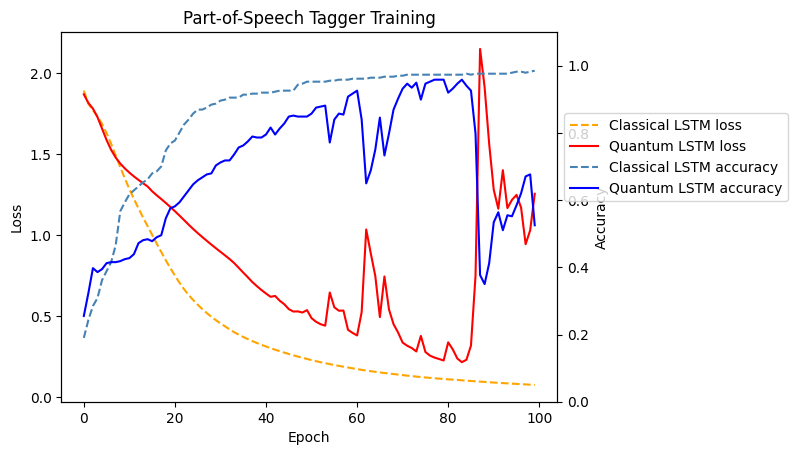

In [ ]:
plot_history(history_classical, history_quantum)